In [13]:
# First we obtain data to compute the log D/P ratio
# The FRED MD dataset is a good (free) source of data
# See 
# Bai, Jushan and Ng, Serena (2002), "Determining the number of factors in approximate factor models".
# McCracken, Michael W. and Ng, Serena (2015), "FRED-MD and FRED-QD: Monthly and Quarterly Databases for Macroeconomic Research".
# Bai, Jushan and Ng, Serena (2019), "Matrix Completion, Counterfactuals, and Factor Analysis of Missing Data".
	

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
url ="https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv"
df = pd.read_csv(url, index_col=0, parse_dates=True)
# keep S&P div yield and S&P 500
df = df[['S&P div yield', 'S&P 500']]

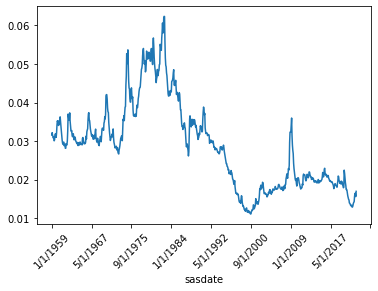

In [14]:
# Transform suggests a transformation of the series given a code, but we stick to the Campbell and Shiller definition
df = df.iloc[1:]
# remove nan
df = df.dropna()

# rename S&P div yield to D/P
# rename S&P 500 to P

df = df.rename(columns={'S&P div yield': 'D/P', 'S&P 500': 'P'})

# D/P is expressed in percentage,
df['D/P'] = df['D/P']/100

# recover D by multiplying by P (and divide by 100)
df['D'] = df['D/P']*df['P']

# compute Delta log D 
df['Delta d'] = np.log(df['D']).diff()
# take logs to D/P 
df['d-p'] = np.log(df['D/P'])
# rename D/P to d-p 

# compute log returns to P
df['r'] = np.log((df['P']+df['D'])/df['P'].shift(1))
df['p'] = np.log(df['P'])

# plot D/P
df['D/P'].plot()
# rotate axis
plt.xticks(rotation=45);


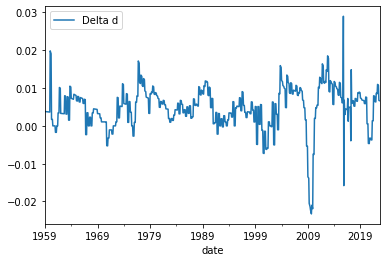

In [15]:
# rename index to date
df.index.name = 'date'
# make index datetime, format is month day year
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')
# plot some of the graphs
df[['Delta d']].plot()


In [16]:
# add two more variables r at t +1 and Delta d at t +1
df['r+1'] = df['r'].shift(-1)
df['Delta d+1'] = df['Delta d'].shift(-1)


In [17]:
# compute forward returns, sum between r today and r 60 months later
tau = 12*6
# first compute cum sums
df['cum_r'] = df['r'].cumsum()
df[f'r+{tau}'] = df['cum_r'].shift(-tau) - df['cum_r']
# remove nan
df = df.dropna()
# regress r+60 on d-p 
import statsmodels.api as sm
X = df['d-p']
y = df[f'r+{tau}']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit() # recall that these are not necessarily the right standard errors
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   r+72   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     4999.
Date:                Mon, 23 Jan 2023   Prob (F-statistic):          2.60e-318
Time:                        09:23:49   Log-Likelihood:                -111.47
No. Observations:                 692   AIC:                             226.9
Df Residuals:                     690   BIC:                             236.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4688      0.100     95.098      0.000       9.273       9.664
d-p            1.9529      0.028     70.706      0.000       1.899       2.007
==============================================================================
Omnibus:                        7.091   Durbin-Watson:                   0.032
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                6.300
Skew:                           0.172   Prob(JB):                       0.0429
Kurtosis:                       2.683   Cond. No.                         35.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

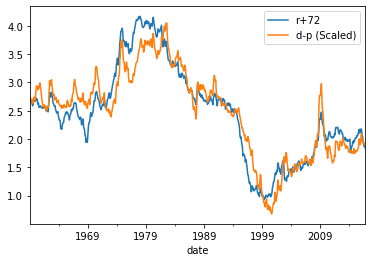

In [18]:
# plot f'r+{tau}' and d-p 
df['d-p (Scaled)'] = df['d-p']*model.params[1]+model.params[0]
df[[f'r+{tau}', 'd-p (Scaled)']].plot()

In [33]:
(df['d-p'] - df['d-p'].mean())/df['d-p'].mean()


date
1959-02-01   -0.041196
1959-03-01   -0.035256
1959-04-01   -0.031673
1959-05-01   -0.028546
1959-06-01   -0.032005
                ...   
2016-05-01    0.072373
2016-06-01    0.073624
2016-07-01    0.081006
2016-08-01    0.082670
2016-09-01    0.079780
Name: d-p, Length: 692, dtype: float64

In [36]:
# Sign restrictions? Regress r+1 on d-p and Delta d+1 on d-p, store the residuals
# regress r+1 on d-p and Delta d+1 on d-p, store the residuals
X = (df['d-p'] - df['d-p'].mean())

y = (df['r+1'] - df['r+1'].mean())*100
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
b_r = model.params[1]
print(f"b_r = {b_r}")


                            OLS Regression Results                            
Dep. Variable:                    r+1   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     86.04
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           2.23e-19
Time:                        09:33:36   Log-Likelihood:                -1840.2
No. Observations:                 692   AIC:                             3684.
Df Residuals:                     690   BIC:                             3693.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.939e-17      0.132  -5.27e-16      1.0

In [37]:
X = (df['d-p'] - df['d-p'].mean())
y = df['Delta d+1']*100
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
b_d = model.params[1]
print(f"b_d = {b_d}")


                            OLS Regression Results                            
Dep. Variable:              Delta d+1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.09033
Date:                Mon, 23 Jan 2023   Prob (F-statistic):              0.764
Time:                        09:34:33   Log-Likelihood:                -600.55
No. Observations:                 692   AIC:                             1205.
Df Residuals:                     690   BIC:                             1214.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4689      0.022     21.374      0.0

In [ ]:
# compute rho for long term reg
x_0 = - df['d-p'].mean()
rho = np.exp(x_0)/(np.exp(x_0)+1)

T = 100 # number of periods
# compute the weighted sum between r+j and r+T weighted by rho**j

# time index
time_ = np.arange(len(df))
for t in time_:
    lhs = sum([rho**j*df['r+1'].iloc[t+j] for j in range(T)])
